In [1]:
from google.colab import files
uploaded = files.upload()

Saving RAVDESS.zip to RAVDESS.zip


In [4]:
import zipfile
import os

zip_path = 'RAVDESS.zip'  # change to your file name
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("ravdess")


In [5]:
def add_white_noise(signal, noise_factor=0.005):
    noise = np.random.randn(len(signal))
    return signal + noise_factor * noise

def time_stretch(signal, rate=0.9):
    return librosa.effects.time_stretch(signal, rate)

def pitch_shift(signal, sr, n_steps=2):
    return librosa.effects.pitch_shift(signal, sr=sr, n_steps=n_steps)


In [6]:
import os
import librosa
import numpy as np
import glob

# Emotion mapping based on RAVDESS file naming
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

X = []
y = []

for filepath in glob.glob("ravdess/**/*.wav", recursive=True):
    try:
        filename = os.path.basename(filepath)
        emotion_code = filename.split("-")[2]
        emotion = emotion_map.get(emotion_code)

        target_emotions = ['neutral', 'happy', 'sad', 'angry']
        if emotion not in target_emotions:
            continue

        # if emotion is None:
        #     print("Skipped unknown emotion:", filepath)
        #     continue

        signal, sr = librosa.load(filepath, sr=16000)

        # Apply augmentations
        signals = [signal]
        signals.append(add_white_noise(signal))
        # signals.append(librosa.effects.time_stretch(signal, rate=0.9))
        # signals.append(librosa.effects.pitch_shift(signal, sr=sr, n_steps=2))

        for augmented in signals:
            # 1. Compute log-Mel spectrogram
            mel = librosa.feature.melspectrogram(y=augmented, sr=sr, n_mels=40)
            log_mel = librosa.power_to_db(mel, ref=np.max)

            # 2. Normalize
            log_mel = (log_mel - np.mean(log_mel)) / np.std(log_mel)

            # 3. Pad or trim to shape (100, 40)
            if log_mel.shape[1] >= 100:
                log_mel = log_mel[:, :100]
            else:
                pad_width = 100 - log_mel.shape[1]
                log_mel = np.pad(log_mel, ((0, 0), (0, pad_width)), mode='constant')

            # 4. Transpose to (100, 40)
            log_mel = log_mel.T

            # 5. Append
            X.append(log_mel)
            y.append(emotion)

    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        continue



In [ ]:
sample = np.expand_dims(log_mel, axis=0)  # Shape: (1, 100, 40)
sample.astype('float32').tofile("sample_input.bin")


In [7]:
import glob
files = glob.glob("ravdess/**/*.wav", recursive=True)
print(f"Found {len(files)} audio files")
print(files[:5])


Found 2880 audio files
['ravdess/Actor_15/03-01-02-02-02-02-15.wav', 'ravdess/Actor_15/03-01-03-01-01-01-15.wav', 'ravdess/Actor_15/03-01-03-01-01-02-15.wav', 'ravdess/Actor_15/03-01-05-02-01-02-15.wav', 'ravdess/Actor_15/03-01-06-02-01-01-15.wav']


In [8]:
X = np.array(X)
y = np.array(y)

print("Data shape:", X.shape, y.shape)

Data shape: (2688, 100, 40) (2688,)




```
Encode Labels
```



In [9]:

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)


Train Model

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(100, 40)),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Use EarlyStopping to avoid overfitting
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights = dict(enumerate(class_weights))

# Now pass this to training:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights
)


Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.3398 - loss: 1.3518 - val_accuracy: 0.3457 - val_loss: 1.2762
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4024 - loss: 1.2156 - val_accuracy: 0.5576 - val_loss: 1.0593
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4986 - loss: 1.0809 - val_accuracy: 0.5613 - val_loss: 0.9655
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5678 - loss: 0.9635 - val_accuracy: 0.6078 - val_loss: 0.9635
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5698 - loss: 0.9590 - val_accuracy: 0.6413 - val_loss: 0.8657
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6173 - loss: 0.8796 - val_accuracy: 0.6487 - val_loss: 0.8084
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6210 - loss: 0.8499 - val_accuracy: 0.5985 - val_loss: 0.8963
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6833 - loss: 0.7653 - val_accuracy: 0.6747 - v

In [11]:
loss, acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {acc:.4f}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9666 - loss: 0.1023
Validation Accuracy: 0.9647


Save and Convert to TFLite

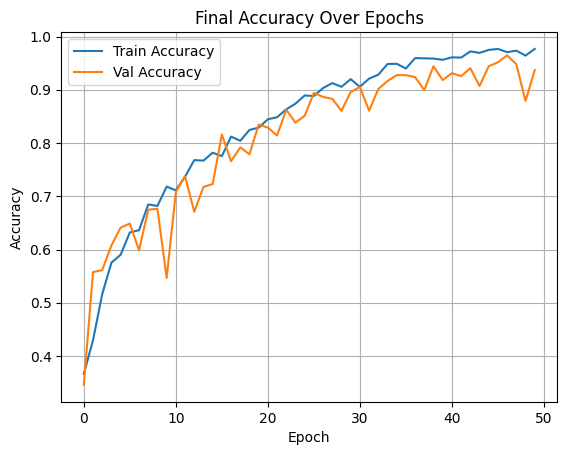

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Final Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


In [14]:
print("Final Train Accuracy:", history.history['accuracy'][-1])
print("Final Val Accuracy:", history.history['val_accuracy'][-1])


Final Train Accuracy: 0.9767441749572754
Final Val Accuracy: 0.9368029832839966


In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

with open("emotion_model.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpjhlva1s8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 40), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139285065445264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139285065449104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139284876903824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139284876905744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139284876902672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139284876906320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139285065449296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139284876906896: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [18]:
import numpy as np
import tensorflow as tf
import librosa

# 1. Load .wav file (must match what was used on Android)
wav_path = '/content/ravdess/Actor_24/03-01-01-01-01-01-24.wav'
signal, sr = librosa.load(wav_path, sr=16000)

# 2. Extract log-Mel spectrogram
n_mels = 40
S = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels)
log_S = librosa.power_to_db(S, ref=np.max)

# 3. Normalize
log_S = (log_S - np.mean(log_S)) / np.std(log_S)

# 4. Pad or truncate to (100, 40)
if log_S.shape[1] >= 100:
    log_S = log_S[:, :100]
else:
    pad_width = 100 - log_S.shape[1]
    log_S = np.pad(log_S, ((0, 0), (0, pad_width)), mode='constant')

# 5. Transpose and reshape for TFLite: (1, 100, 40)
log_S = log_S.T[np.newaxis, :, :].astype(np.float32)

# 6. Load TFLite model
interpreter = tf.lite.Interpreter(model_path='emotion_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], log_S)
interpreter.invoke()

output = interpreter.get_tensor(output_details[0]['index'])[0]

# 7. Print results
emotion_labels = ['angry', 'happy', 'neutral', 'sad']
for i, prob in enumerate(output):
    print(f"{emotion_labels[i]}: {prob*100:.2f}%")

print("\nPredicted Emotion:", emotion_labels[np.argmax(output)])


angry: 0.07%
happy: 0.03%
neutral: 93.62%
sad: 6.27%

Predicted Emotion: neutral
